In [2]:
import pandas, numpy, time
from multiprocessing import Pool, cpu_count

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

N_ROWS = 3

Populating the interactive namespace from numpy and matplotlib


# III. Grouping and Normalizing Officers:
## Abstract 



## 0. Import and cleansing:
Importing the dataset all lowercase, adding a parent_id column. Removing details from some names; ex: { boshen ltd./137-93, boshen ltd./136-83, boshen ltd./134-61 }. An upgrade could move these details to the notes. 

In [3]:
officer_nodes = pandas.read_csv('data/raw/nodes.intermediary.csv', usecols=['node_id', 'name', 'countries'], index_col='node_id')
officer_nodes['parent_id'] = 0

officer_nodes = officer_nodes.applymap( lambda _str: _str.lower() if isinstance( _str,str ) else _str )

def remove_punctuation(_str):
    # TODO: replace with string.puctuation 
    for punc in [ ';', '#', ',', '|', '\t', '"', '/', '.', '(', ')', '-', '^', '_' ]:
        _str = _str.replace( punc, ' ' )
    return ' '.join(_str.split())
    
officer_nodes.name = officer_nodes.name.map( lambda _str: remove_punctuation(_str) if isinstance( _str,str) else _str )

officer_nodes.head( N_ROWS )

,name,countries,parent_id
node_id,,,
11000001,michael papageorge mr,south africa,0
11000002,corfiducia anstalt,liechtenstein,0
11000003,david ronald,monaco,0


This database is relatively large, thankfully over 50% of the entries seemed to be duplicates:

In [4]:
def count_duplicates( df, col ):
    duplicates = df[ df.duplicated([ col ]) ]

    total = df.shape[0]
    unique = len( df[ col ].unique() )

    duplicate_count = total - unique
    duplicate_percent = int( (duplicate_count * 100) / total )

    print( f'* Total entries: {total} \n* Duplicates: {duplicate_count} or {duplicate_percent}%' )

count_duplicates( officer_nodes, 'name' )

# for record
total = officer_nodes.shape[0]

* Total entries: 14110 
* Duplicates: 231 or 1%


## 1. Normalizing "bearer" nodes:

In [5]:
officer_nodes.groupby('name').size().sort_values(ascending=False).head( N_ROWS )

name
companhia de navegação norsul      2
p s j alexander & co ltd           2
estudio cr caterina gomez lagas    2
dtype: int64

Bearers cannot be grouped into a single ID as they could represent different officers, thus only typos and translations are normalized.

In [6]:
bearer_nodes = officer_nodes.name.isin(
    ['the  bearer', 'el portador', 'bearer', 'baerer',
    'the baerer', 'the bearer', 'the beare', 'the ebarer',
    'the beearer', 'the beared', 'el portaror', 'el portdor',
    'the berear', 'el protador', 'the barer', 'bearr', 'the bear', 
    'elportador', 'al protador', 'al portador', 'to bearer'] 
    ) 
officer_nodes.loc[ bearer_nodes, 'name' ] = 'the bearer'

# to quantify results
bearer_nodes = officer_nodes[officer_nodes.name == 'the bearer']

officer_nodes.groupby('name').size().sort_values(ascending=False).head( N_ROWS )

name
companhia de navegação norsul      2
p s j alexander & co ltd           2
estudio cr caterina gomez lagas    2
dtype: int64

## 2. Removing direct duplicates:
27% of the rest of the nodes (non bearer nodes) are exact duplicates:

In [7]:
officer_nodes = officer_nodes[ officer_nodes.name != 'the bearer']

print('OTHER NODES')
count_duplicates( officer_nodes, 'name' )

OTHER NODES
* Total entries: 14110 
* Duplicates: 231 or 1%


Maping the parent's ids to their exact duplicates.

In [8]:
duplicates = officer_nodes.name.duplicated(keep=False)

def map_parent_id(df):
    # parent_id is the first row's node_id
    parent_id = df.index[0]
    # children are the rest of the rows
    df.iloc[ 1:, df.columns.get_indexer(['parent_id']) ] = parent_id
    return df

def gapply_parallel(df_group, func):
    t1 = time.time()

    df_list = [ group for name, group in df_group ]

    with Pool( cpu_count() ) as pool:
        results = pool.map(func, df_list)

    result_df = pandas.concat( results )

    print( f'* Total in:', time.time()-t1 )
    return result_df

group_duplicates = officer_nodes.loc[ duplicates ].groupby('name')

matches = gapply_parallel( group_duplicates, map_parent_id )

officer_nodes.update(matches)
officer_nodes.parent_id = officer_nodes.parent_id.astype('Int64')

* Total in: 0.3736858367919922


In [9]:
duplicates_mapped = officer_nodes[ officer_nodes.parent_id > 0]
print('Duplicates mapped:', duplicates_mapped.shape[0])

duplicates_mapped.head(N_ROWS)

Duplicates mapped: 231


,name,countries,parent_id
node_id,,,
11001828,leumi overseas trust corporation limited,jersey;united kingdom,11000883
11002119,p s j alexander & co ltd,united kingdom,11001787
11002221,acquarius trust co ltd,NaN,11001411


Saving the results in the clean 'data/output/edges.csv':

In [10]:
edges = pandas.read_csv('data/processing/edges.csv')
duplicate_nodes = duplicates_mapped.index

def duplicate_to_parent(_id):
    if _id in duplicate_nodes:
        return duplicates_mapped.loc[_id, 'parent_id']
    return _id
    
edges['start_id'] = edges['start_id'].apply(duplicate_to_parent)
edges['end_id'] = edges['end_id'].apply(duplicate_to_parent)

## 3. Splitting companies and people:
The dataset is a mix of companies and people's name, we ought to separate these types of entities for further analysis.

In [11]:
officer_nodes = officer_nodes.loc[(officer_nodes.parent_id == 0) & officer_nodes.name.notna()]

To extract companies, a corpus of tokens was compiled by selecting relevant words from a frequency analysis on all strings. Laborious process but very accurate as it eliminates errors from typos.

In [12]:
company_tokens = set(open("data/company_markers.txt", "r").read().split())

def is_company(_str):
    # s.a. stands for sociedad anonima (anonymous company)
    if ' s a' in _str:
        return True
    
    _list = _str.split()
    for w in _list:
        if w in company_tokens:
            return True
    return False

companies = officer_nodes.loc[officer_nodes.name.apply(is_company)] # boolean indexing returns a copy
companies = officer_nodes.loc[companies.index]  # as a view

names = officer_nodes.drop(companies.index)
names = names.loc[ names.name.notna() ]

## 4. Companies:
More duplicates are found by simply removing all digits from the strings and sorting them. The digits are assumed to be details, typos or other unecessary markers.

In [13]:
def remove_digits(_str):
    return ''.join(list(filter(lambda x: not x.isdigit(), _str)))

def sort_string(_str):
    _str = _str.split()
    _str.sort() 
    return ' '.join(_str)

companies['name'] = companies['name'].apply(remove_digits)
companies['name'] = companies['name'].apply(sort_string)

count_duplicates(companies, 'name')

* Total entries: 6384 
* Duplicates: 16 or 0%


Removing duplicates:

In [14]:
def remove_duplicates(df, edges):
    duplicates = df.name.duplicated(keep=False)
    group_duplicates = df.loc[ duplicates ].groupby('name')

    matches = gapply_parallel( group_duplicates, map_parent_id )

    df.update(matches)
    df.parent_id = companies.parent_id.astype('Int64')

    edges['start_id'] = edges['start_id'].apply(duplicate_to_parent)
    edges['end_id'] = edges['end_id'].apply(duplicate_to_parent)
    
    return df, edges

companies, edges = remove_duplicates(companies, edges)

duplicate_companies = companies[companies.parent_id > 0]
companies = companies.drop(duplicate_companies.index)

duplicate_companies.head(N_ROWS)
edges.to_csv('data/processing/edges.csv', index=False)

* Total in: 0.26160526275634766


## 5. People:


In [15]:
to_remove = ['the', 'mr', 'm', 'miss', 'bearer', 'share', 
             'shares', 'beaer', 'warrant']

# TODO : 
#remove_digit
#remove_tokens
#sort_string

def sanitize_names(_str):
    _str = remove_digits(_str)
    
    as_list = _str.split()
    as_list = [ w for w in as_list if w not in to_remove ]
    
    as_list.sort()
    
    if len(as_list) > 0:
        return ' '.join(as_list)
    else:
        return numpy.NaN

names.name = names.name.map( lambda _str: sanitize_names(_str) if isinstance( _str,str) else _str )
names = names.loc[ names.name.notna() ]

count_duplicates(names, 'name')

* Total entries: 7495 
* Duplicates: 25 or 0%


As important details have been removed, like the number of shares the person owns, we create new edges of type 'is'.

In [16]:
duplicate_names = names[names.name.duplicated(keep=False)]
group_duplicates = duplicate_names.groupby('name')

matches = gapply_parallel( group_duplicates, map_parent_id )

names.update(matches)

new_edges = names[names.parent_id > 0].drop(['name', 'countries'], axis=1)
new_edges['type'] = 'is'
new_edges['text'] = 'same person'

names = names[names.parent_id == 0]
new_edges.head(N_ROWS)

* Total in: 0.1606917381286621


,parent_id,type,text
node_id,,,
11002454,11002026,is,same person
11003019,11002152,is,same person
11003099,11000850,is,same person


In [17]:
new_edges.to_csv('data/processing/is.edges.csv')

## 6. Results:

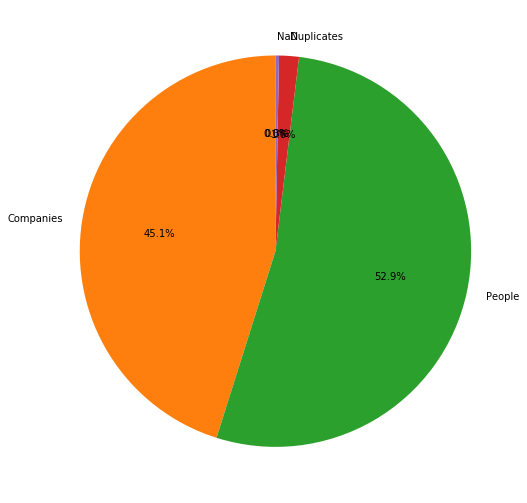

In [22]:
total_duplicates = ( duplicates_mapped.shape[0] 
                    + duplicate_companies.shape[0]
                    + duplicate_names.shape[0] )

data = numpy.array([ bearer_nodes.shape[0],
                   companies.shape[0],
                   names.shape[0],
                   duplicates_mapped.shape[0] ])

na = total - data.sum()
data = numpy.append(data, na)

s = pandas.Series(data, index=['the bearer', 'Companies', 'People', 'Duplicates', 'NaN'],
                 name=' ')

#as percentage of the total
s.apply(lambda x: (x*100)/total)

s.plot.pie(y=s.index, autopct='%1.1f%%', startangle=90)

TODO: save type people and company in original df